# ***Model Comparison with Pipeline***
---
## ***Telco Customer Churn***

- Siniflandirma projesinde Telco Customer Churn verileriyle calisarak musterilerin kacis durumunu tahmin edecegiz. Veri seti [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn)'dan elde edilmisitir.
- ***Veri Seti:*** Telco Customer Churn
- ***Arastirma konusu:*** Musteri kacis durumu hedef degisken, diger degiskenler aciklayici degisken olmak uzere Musteri kacis durumunu tahmin eden bir model olusturulacaktir.
- Kesifsel Veri Analizi daha once [surada](https://github.com/ahmetpergamum/datascience/blob/master/10_ml_classification_customer_churn/eda_churn.ipynb) yapildigindan, burada sadece model olusturma ve test adimlari ile ilgilenecegiz.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# classifiers, regressors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost as xgb
# pipeline meta model
from sklearn.pipeline import Pipeline
# olceklendirme
from sklearn.preprocessing import StandardScaler
# polinom ozellikler
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirma
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# cross validation
from sklearn.model_selection import cross_validate, cross_val_score
# hiperparametre tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.6f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
font_title = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
font_axis  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

##### [Exploratory Data Analysis (EDA) Adimlari](https://github.com/ahmetpergamum/datascience/blob/master/10_ml_classification_pcustomer_churn/eda_churn.ipynb)
---
## ***Grid Search ile Model Karsilastirmasi***


In [3]:
# veri setini dataframe icerisine yukle
customer_churn = pd.read_csv('data/telco_customer_churn_clean.csv')

customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### ***Degiskenleri Donusturme***
#### ***Metin Degiskenlerin Sayisal Degiskenlere Donusturulmesi***
- One Hot Encoding (get_dummies)

In [4]:
continuous = ['tenure', 'TotalCharges', 'MonthlyCharges']

In [5]:
categoric = [col for col in customer_churn.columns if customer_churn[col].nunique()<10]

In [6]:
categoric

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [7]:
# kategorik degiskenlerin hepsine get dummies uygula
pd.get_dummies(customer_churn[categoric],drop_first=True)

,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0
7039,0,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0
7040,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
7041,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [8]:
dummy_df = pd.get_dummies(customer_churn[categoric],drop_first=True)
customer_churn_one_hot = pd.concat([customer_churn, dummy_df], axis=1)

In [9]:
customer_churn_one_hot = customer_churn_one_hot.drop(categoric, axis=1)

In [10]:
customer_churn_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   gender_Male                            7043 non-null   uint8  
 5   Partner_Yes                            7043 non-null   uint8  
 6   Dependents_Yes                         7043 non-null   uint8  
 7   PhoneService_Yes                       7043 non-null   uint8  
 8   MultipleLines_No phone service         7043 non-null   uint8  
 9   MultipleLines_Yes                      7043 non-null   uint8  
 10  InternetService_Fiber optic            7043 non-null   uint8  
 11  Inte

- Label encoding(replace, scikitlearn LabelEncoder)

---
### ***Tahmin Modeli - Pipeline***
Meta model olarak dusunulebilecek pipeline sinifi ile modelleri test ederek en iyi performans veren modeli sececegiz.

In [11]:
# hedef degisken
y = customer_churn_one_hot['Churn_Yes']
# aciklayici degiskenler
X = customer_churn_one_hot.drop(['customerID', 'Churn_Yes'], axis=1)

In [12]:
# egitim ve test kumesini ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
%%time
# hucrenin calisma suresini tutacak

# pipeline tanimla
# ilk model knn tanimlandi 
pipe = Pipeline([('classifier', KNeighborsClassifier())])

# aranacak model ve parametreleri belirle
param_grid = [{'classifier': [KNeighborsClassifier()],
               'classifier__n_neighbors': np.arange(3,5),
               'classifier__weights': ['uniform', 'distance']},
              {'classifier': [LogisticRegression()],
               'classifier__C': np.logspace(-1,2,4)},
              {'classifier': [LogisticRegression(solver='liblinear')],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': np.logspace(-1,2,4)},
              {'classifier': [DecisionTreeClassifier()],
               'classifier__max_depth': np.arange(3,7)},
              {'classifier': [RandomForestClassifier()],
               'classifier__max_depth': np.arange(3,7)},
              {'classifier': [SVC()],
               'classifier__gamma': [0.1, 1.0, 10.0, 100.0, 'scale'],
               'classifier__C': np.logspace(-1,2,4)},
              {'classifier': [SVC(kernel='linear')],
               'classifier__C': np.logspace(-1,2,4)},
              {'classifier': [XGBClassifier()],
               'classifier__gamma': [0, 0.1, 1.0, 10.0, 100.0],
               'classifier__reg_alpha': [0, 0.1, 1.0, 10.0, 100.0], 
               'classifier__reg_lambda': np.logspace(-1,2,4), 
               'classifier__max_depth': np.arange(3,7)},
              {'classifier': [LGBMClassifier()], 
               'classifier__reg_alpha': [0, 0.1, 1.0, 10.0, 100.0], 
               'classifier__reg_lambda': [0, 0.1, 1.0, 10.0, 100.0], 
               'classifier__max_depth': np.arange(3,7)}
             ]
# gridsearch nesnesi tanimla
grid_churn = GridSearchCV(estimator=pipe, 
                          param_grid=param_grid, 
                          scoring=['roc_auc','f1','accuracy'],
                          cv=7, n_jobs=4, return_train_score=True, refit='roc_auc')
# modeli egit
grid_churn.fit(X_train, y_train)

# sonuclar
print("Best params: \n{}\n".format(grid_churn.best_params_))
print("Best cross-validation score: \n{:.2f}\n".format(grid_churn.best_score_))
print("Test-set score: \n{:.2f}\n".format(grid_churn.score(X_test, y_test)))


Best params: 
{'classifier': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=1.0, reg_lambda=100.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'classifier__max_depth': 3, 'classifier__reg_alpha': 1.0, 'classifier__reg_lambda': 100.0}

Best cross-validation score: 
0.85

Test-set score: 
0.83

CPU times: user 23.9 s, sys: 873 ms, total: 24.8 s
Wall time: 1h 11min 2s


In [23]:
# sonuclari df olarak kaydet
grid_churn_df_1 = pd.DataFrame(grid_churn.cv_results_)
grid_churn_df_1.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__weights,param_classifier__C,param_classifier__penalty,param_classifier__max_depth,param_classifier__gamma,param_classifier__reg_alpha,param_classifier__reg_lambda,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,mean_train_f1,std_train_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.019,0.003,0.043,0.005,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n m...",3,uniform,NaN,NaN,NaN,NaN,NaN,NaN,"{'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', ...",0.740,0.748,0.713,0.716,0.700,0.719,0.717,0.722,0.015,531,0.919,0.918,0.920,0.922,0.926,0.921,0.923,0.921,0.003,0.506,0.540,0.481,0.470,0.474,0.485,0.525,0.497,0.025,408,0.716,0.712,0.710,0.716,0.727,0.717,0.728,0.718,0.006,0.760,0.769,0.759,0.745,0.727,0.747,0.766,0.753,0.014,515,0.859,0.857,0.856,0.860,0.864,0.859,0.864,0.860,0.003


In [39]:
# sirala
grid_churn_df_1 = grid_churn_df_1.sort_values(by='mean_test_roc_auc', ascending=False)
# ilk siradakileri goster
grid_churn_df_1.loc[:,['param_classifier','mean_train_accuracy', 'mean_test_accuracy', 'mean_train_roc_auc',
                       'mean_test_roc_auc','mean_train_f1','mean_test_f1']].head(5)

,param_classifier,mean_train_accuracy,mean_test_accuracy,mean_train_roc_auc,mean_test_roc_auc,mean_train_f1,mean_test_f1
462,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n im...",0.816915,0.806887,0.865657,0.852331,0.624246,0.603316
457,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n im...",0.816531,0.806354,0.866033,0.852319,0.623749,0.603779
259,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_by...",0.820938,0.807775,0.873454,0.852018,0.629926,0.604379
482,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n im...",0.819163,0.805821,0.870869,0.851931,0.630469,0.604284
492,"LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n im...",0.816471,0.805822,0.865928,0.851899,0.622208,0.602100


In [25]:
# her bir classifier in en iyi degerleriyle ayri bir df olustur
best_of_classifiers_1 = pd.DataFrame([])
for classifier in grid_churn_df_1.param_classifier.unique():
    best_of_classifiers_1 = pd.concat([best_of_classifiers_1,grid_churn_df_1[grid_churn_df_1['param_classifier']==classifier].head(5)])

In [ ]:
best_of_classifiers_1

In [65]:
#best_of_classifiers_1.loc[279,'param_classifier']

In [27]:
# adlandirma olmali, grafik gosterimi icin
def get_names(model_df):
    name_list = []
    for i in model_df.index:
        classifier = model_df.loc[i,'param_classifier']
        name = classifier.__class__.__name__    
        if (name == 'SVC'):
            name = name + '_' + classifier.kernel
        elif (name == 'LogisticRegression'):
            name = name.split('ression')[0]
            name = name + '_' + classifier.solver
        else:
            name = name.split('assifier')[0]

        name_list.append(name)
        
    return name_list

print(get_names(best_of_classifiers_1))

['XGBCl', 'XGBCl', 'XGBCl', 'XGBCl', 'XGBCl', 'LGBMCl', 'LGBMCl', 'LGBMCl', 'LGBMCl', 'LGBMCl', 'LogisticReg_liblinear', 'LogisticReg_liblinear', 'LogisticReg_liblinear', 'LogisticReg_liblinear', 'LogisticReg_liblinear', 'LogisticReg_lbfgs', 'LogisticReg_lbfgs', 'LogisticReg_lbfgs', 'LogisticReg_lbfgs', 'SVC_linear', 'SVC_linear', 'SVC_linear', 'SVC_linear', 'RandomForestCl', 'RandomForestCl', 'RandomForestCl', 'RandomForestCl', 'DecisionTreeCl', 'DecisionTreeCl', 'DecisionTreeCl', 'DecisionTreeCl', 'SVC_rbf', 'SVC_rbf', 'SVC_rbf', 'SVC_rbf', 'SVC_rbf', 'KNeighborsCl', 'KNeighborsCl', 'KNeighborsCl', 'KNeighborsCl']


In [28]:
# adlandirma olmali, grafik gosterimi icin
best_of_classifiers_1['classifier'] = get_names(best_of_classifiers_1)

In [ ]:
# her bir classifier in skor degerlerini incele
best_of_classifiers_1.loc[:,['classifier','mean_train_accuracy', 'mean_test_accuracy','mean_train_roc_auc',
                             'mean_test_roc_auc','mean_train_f1','mean_test_f1']]

***Grafik Incelemesi***

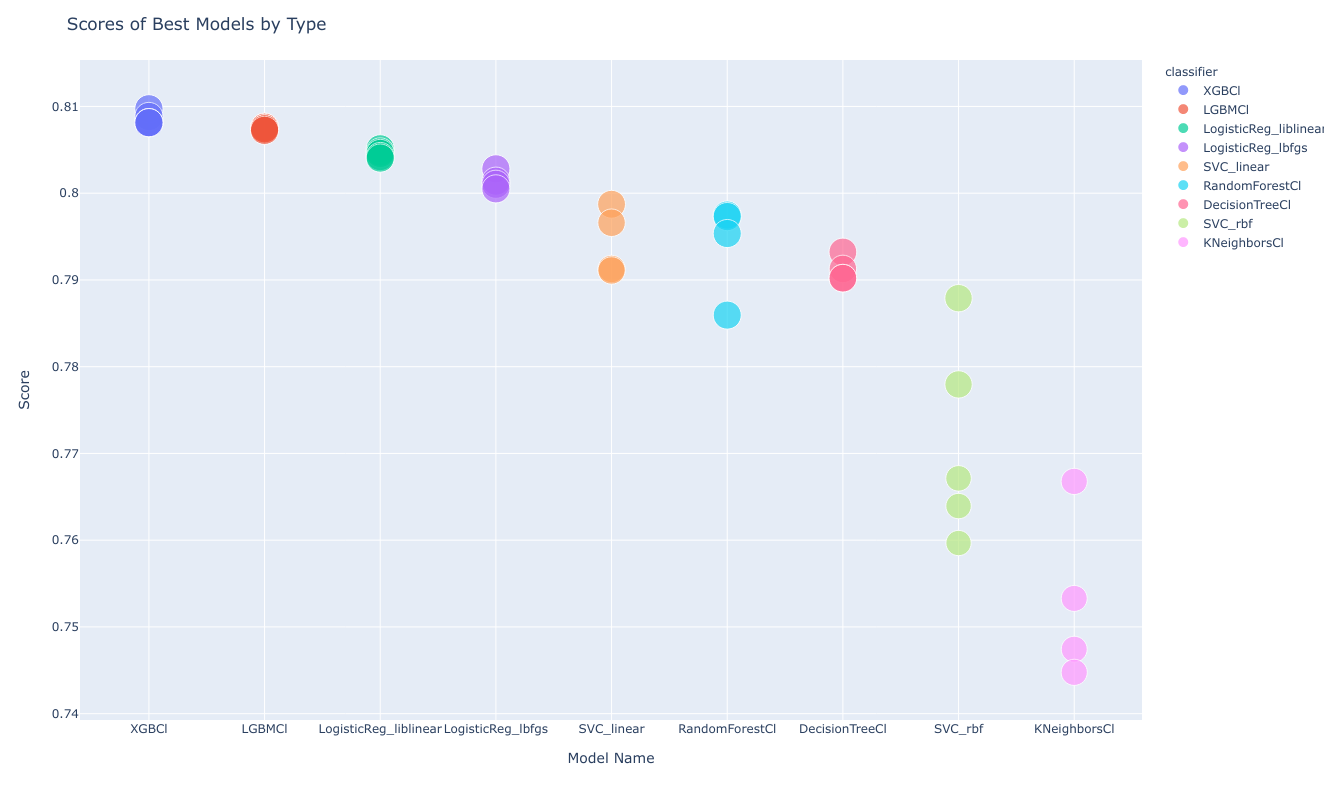

In [40]:
fig = px.scatter(best_of_classifiers_1, x="classifier", y="mean_test_accuracy", color="classifier",
                 size='mean_test_roc_auc', hover_data=['mean_test_accuracy','mean_test_roc_auc',
                                                       'mean_test_f1'])
# layout degistir
fig.update_layout(title='Scores of Best Models by Type', legend_orientation="v",
                   xaxis_title='Model Name',
                   yaxis_title='Score', width=1300, height=800, )
fig.show()

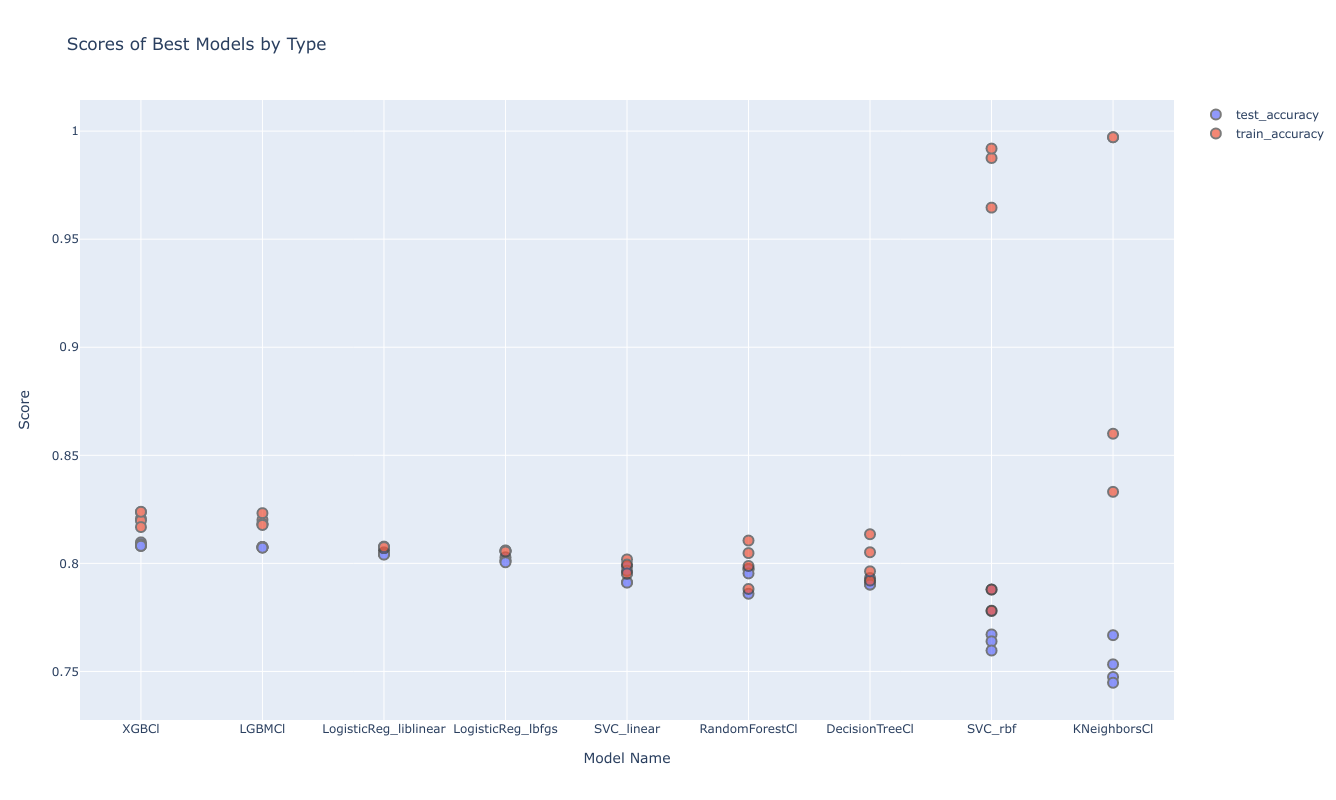

In [42]:
#fig = px.scatter(best_of_classifiers, x="classifier", y="mean_test_accuracy", color="classifier",
#                 size='mean_test_roc_auc', hover_data=['mean_test_accuracy','mean_test_roc_auc',
#                                                       'mean_test_f1'])
fig = go.Figure()
fig.add_trace(go.Scatter(x=best_of_classifiers_1['classifier'], 
                         y=best_of_classifiers_1['mean_test_accuracy'],
                         name='test_accuracy', 
                         mode='markers', opacity=0.7))
fig.add_trace(go.Scatter(x=best_of_classifiers_1['classifier'],
                         y=best_of_classifiers_1['mean_train_accuracy'],
                         name='train_accuracy', 
                         mode='markers', opacity=0.7))
# marker size belirle
fig.update_traces(mode='markers', marker_size=10, marker_line_width=2)
# layout degistir
fig.update_layout(title='Scores of Best Models by Type', legend_orientation="v",
                   xaxis_title='Model Name',
                   yaxis_title='Score', width=1300, height=800, )
fig.show()

### ***Secilen Model***

In [73]:
# secilen model
best_of_classifiers_1.loc[279,'params']

{'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='binary:logistic', random_state=None, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=None,
               tree_method=None, validate_parameters=False, verbosity=None),
 'classifier__gamma': 1.0,
 'classifier__max_depth': 6,
 'classifier__reg_alpha': 1.0,
 'classifier__reg_lambda': 100.0}

***accuracy, f1 ve auc skor hesaplama***

In [74]:
# secilen modeli olustur ve test et
xgb_cl = XGBClassifier(max_depth=6, reg_alpha=1, reg_lambda=100, gamma=1)
# modeli egit
xgb_cl.fit(X_train, y_train)
# tahmin olustur
y_pred = xgb_cl.predict(X_test)
# auc score hesaplamada olasilik gerekli
y_pred_prob = xgb_cl.predict_proba(X_test)
print('accuracy  : {:.2f}'.format(accuracy_score(y_test, y_pred))) 
print('f1 score  : {:.2f}'.format(f1_score(y_test, y_pred))) 
# auc score da predict prob nin 1 inci sutunu yani survive olma durumunu aliriz
print('auc score : {:.2f}'.format(roc_auc_score(y_test, y_pred_prob[:,1])))

accuracy  : 0.79
f1 score  : 0.56
auc score : 0.83


***classsification_report***

In [75]:
print('classification report : \n{}'.format(classification_report(y_test, y_pred)))

classification report : 
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1041
           1       0.62      0.51      0.56       368

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



***cross_val_score***

In [76]:
# cross_val_score ile skor sonucunu al
cv_auc = cross_val_score(estimator=xgb_cl, X=X, y=y, cv=10, scoring='accuracy')
# cv skorlarinin ortalamasi
print('cv accuracy mean: {:.4f}'.format(cv_auc.mean()))

cv accuracy mean: 0.8052


In [77]:
# cross_val_score ile skor sonucunu al
cv_auc = cross_val_score(estimator=xgb_cl, X=X, y=y, cv=10, scoring='roc_auc')
# cv skorlarinin ortalamasi
print('cv auc score mean: {:.4f}'.format(cv_auc.mean()))

cv auc score mean: 0.8472


***feature_importances_***

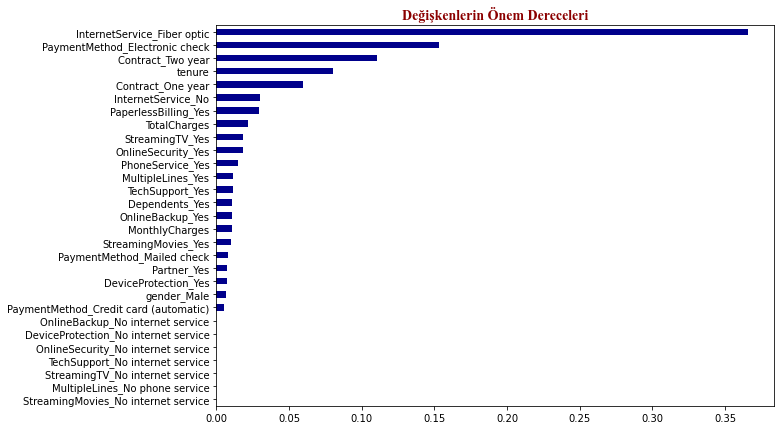

In [79]:
# ozellik oneminden once model fit edilmeli
xgb_cl.fit(X_train, y_train)
# ozellik onem dereceleri
# onem derecelerinden seri olustur
önem_dereceleri = pd.Series(data=xgb_cl.feature_importances_,index= X_train.columns)
# sirala
önem_dereceleri_sıralı = önem_dereceleri.sort_values()
# grafigini ciz
plt.figure(figsize=(10,7))
önem_dereceleri_sıralı.plot(kind='barh', color='darkblue')
plt.title('Değişkenlerin Önem Dereceleri', fontdict=font_title)
plt.show()

---
### ***Sonuc***
- Test sonuclarindan da gorulecegi uzere Boosting algoritmalarin diger modellerden daha iyi performans gosterdigi belirlenmistir.
- Testlerde en iyi sonuclari veren XGBoost algoritmasi ile tahmin modeli olusturulacaktir.